# Report for Seedbox technical test
​														**Vincent Gruson (date: 2018/01/28)**

## Introduction

The purpose of this test is to extract relevant information regarding an A/B test performed on a website hosted by Seedbox. More particularly, the impact of the modification of the cancellation procedure is analysed. Initially, members were able to cancel their subscription by filling a web form. What is proposed here is to force them to call-in to the customer service line in order to cancel. 

To perform the analysis, two files are provided, testSamples.csv and transData.csv: 

* testSamples gives a list of unique users who participated in the A/B test (59721 unique ID, 14835 (24.8%) in the Test/call-in group, 44886 (75.2%) in the Control/web form group). This file aims at knowing the group (Control/Test) in which the unique ID belongs.
* The second file provides the number and type of transactions of randomly selected users, picked up from the testSamples.csv file.

From this test, four questions are asked: 

1. What is the approximate probability distribution between the test group and the control group?
2. Is a user that must call-in to cancel more likely to generate at least 1 additional rebill?
3. Is a user that must call-in to cancel more likely to generate more revenues?
4. Is a user that must call-in more likely to produce a higher chargeback rate?

## Results summary

Before providing a deep analysis, here are the answers of the above questions given in a concise way. 

1. The probability distributions of the different transactions are :

|  Group  | Rebill | Refund | Chargeback | Total |
|---------| :----: | :----: | :--------: | :---: |
| Control | 0.505  | 0.025  |   0.014    | 0.545 |
|  Test   |  0.43  | 0.016  |   0.008    | 0.454 |
|  Total  | 0.935  | 0.041  |   0.022    |   1   |

The probability distributions of the two groups in term of unique sample ID inside transData.csv are: 

|  Group  | Rebill | Refund | Chargeback | Total |
| :-----: | :----: | :----: | :--------: | :---: |
| Control | 0.345  | 0.032  |   0.020    | 0.397 |
|  Test   | 0.571  | 0.021  |   0.011    | 0.603 |
|  Total  | 0.916  | 0.054  |   0.030    |   1   |

2. Users who must call-in are more likely to generate at least 1 additional rebill. The probability that users in the control group generate at least 1 additional rebill is around 87%, while being up to 95% in the test group. 

3. The mean revenue from the control group is about 83\$ and about 58\$ for the test group, with respective standard deviation of 103\$ and 55\$. This means that people from the test group are less likely to generate more revenues than users from the control group. However, the high standard deviation of the control group indicates that even if they generate more revenues on average, they can also ask for more refunds or chargebacks.

4. Users that must call-in are less likely to produce a higher chargeback rate. The chargeback rate is defined as the ratio between the number of "chargeback" transactions over the number of "rebill" transactions. In the control group, this chargeback rate is about $2.7\%$, while being about $1.6\%$  in the test group, thus leading to an absolute $0.9\%$ percent chargeback rate decrease ($35\%$ relative decrease).

**Now, a more in-depth study is proposed.** 


# Load the data and data cleaning

In [1]:
# Load all the standard libraries for data analysis

import pandas as pd
import numpy as np

from scipy.stats import ttest_ind_from_stats
from scipy.stats import norm, beta

import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.style.use('ggplot')


# Load the data sets and remove duplicates if there are any.

Df_Sample = pd.read_csv('testSamples.csv')
Df_Sample = Df_Sample.drop_duplicates()

# There is nothing interesting in Df_Sample apart from the connexion between sample_id and 
# test_group. I'll use Df_sample to link the sample_id's to their respective test_group in Df_trans

Df_Trans = pd.read_csv('transData.csv')
Df_Trans = Df_Trans.drop_duplicates()

We can see that there are several transactions per sample_id. To make the analysis easier, I'm conbining the two data sets using the merge function. I'm taking the sample_id column as reference for both dataframe. From that, I can add the "test_group" column of testSample.csv to the transData.csv file, but only for the sample_id appearing in transData.

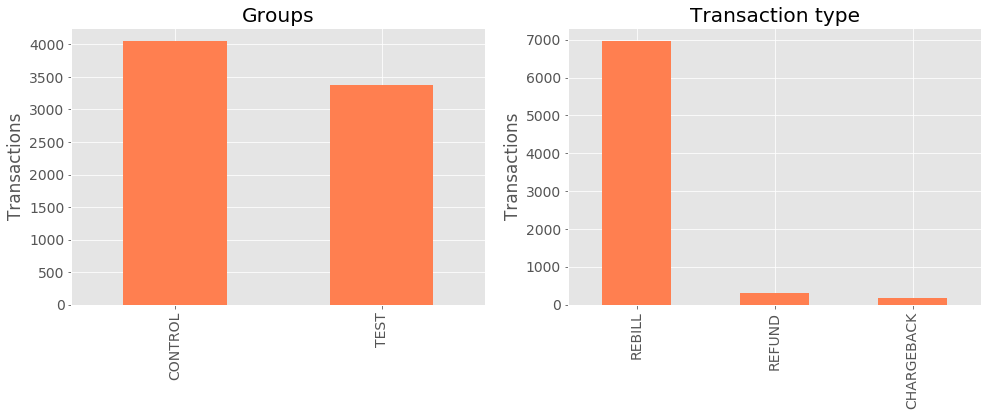

In [2]:
# The variable name "Df_combine_temp" is not optimal, but it is really just a temporary variable.
# I'm not doing anything with it, except from the plot below. 

Df_combine_temp = pd.merge(Df_Trans,
                 Df_Sample[['sample_id','test_group']],
                 on='sample_id')

rcParams.update({'font.size': 14})

# Plotting the different populations contained in Df_combine_temp

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14,6))
Df_combine_temp['test_group'].value_counts().plot(ax = axes[0], kind='bar',
                                       color="coral", fontsize=14,
                                       title = 'Groups');
axes[0].set_xticklabels(['CONTROL', 'TEST'])
axes[0].set_ylabel('Transactions')

Df_combine_temp['transaction_type'].value_counts().plot(ax = axes[1],kind='bar',
                                             color="coral", fontsize=14,
                                            title = 'Transaction type');
axes[1].set_ylabel('Transactions')
plt.tight_layout()
plt.savefig('TotalTransactions.png', dpi=200)
plt.show()



**Figure 1**:Distribution of the different transactions of the studied samples. *Left* : comparison of the total number of transactions between the control and the test group. *Right*: comparison between the different types of transactions, independently of the group of origin.

* First, by looking at the left Figure, we can see that the number of transaction in the control group is similar to this of the test group.
* Second, We see that no matter the group the population belongs to, they are more likely to generate at least 1  REBILL, rather than requiring a chargeback.
* By looking at Df_combine_temp, I've noticed that the transaction_amount for a given sample_id is always the same. Thus, we can group the transaction_amount in order to obtain a single line summing up a sample_id transactions. I'm also adding an extra column call "total_expense" which is defined as the product between the transaction_amount and counts columns.

In [3]:
# we count the number of transaction for each unique user in sample_id and we create a new column called "counts".

Df_combine = Df_combine_temp.groupby(['sample_id', 'test_group', 'transaction_type', 'transaction_amount'])\
                            .size().reset_index(name='counts')

# I'm separating the two groups, for clarity    
Control_Trans = Df_combine[Df_combine['test_group'] == 0]

# I add an extra column called "total_expense" = counts*transaction_amount
Control_Trans = Control_Trans.assign(total_expense=pd.Series(
    Control_Trans['transaction_amount'].mul(Control_Trans['counts'])).values
                                    )
Test_Trans = Df_combine[Df_combine['test_group'] == 1]
Test_Trans = Test_Trans.assign(total_expense=pd.Series(
    Test_Trans['transaction_amount'].mul(Test_Trans['counts'])).values
                                    )
Test_Trans.head() 

,sample_id,test_group,transaction_type,transaction_amount,counts,total_expense
0,11,1,REBILL,24.95,2,49.90
1,32,1,REBILL,29.95,4,119.80
6,137,1,REBILL,29.95,2,59.90
7,138,1,REBILL,24.95,1,24.95
8,249,1,REBILL,39.95,1,39.95


## 1. What is the approximate probability distribution between the test group and the control group?

*Relevant information for this question have been given in the Results summary section. Here, one can find the table and Figure of the different populations observed during this study.* 

I'm now comparing the population of unique sample_ID who did either a REBILL, CASHBACK or REFUND. I'm also plotting that in a hist chart to get a visual. 

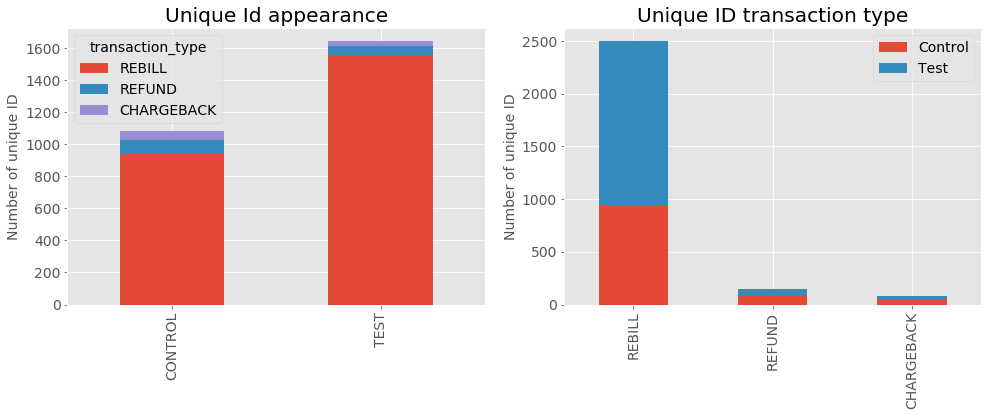

In [4]:
# I'm creating a small dataframe with all the relative population (Control/Test and Rebill/Refund/Chargeback).
# From that, I can extract the group distributions. 

Group_Trans_Compare = pd.DataFrame(np.array([[Control_Trans['transaction_type'].value_counts()[i],
                                              Test_Trans['transaction_type'].value_counts()[i]]
                                             for i in range(0,3)]),
                                   columns = ['Control','Test']
                       )

Group_Trans_Compare.insert(0, 'transaction_type', ['REBILL','REFUND','CHARGEBACK'])


# Useful for the left plot (distribution of Control and test group).
GTC_transpose = Group_Trans_Compare.set_index('transaction_type').T

fig2, axes = plt.subplots(nrows=1, ncols=2,figsize=(14,6))
GTC_transpose.plot(ax = axes[0], kind='bar', stacked = True, fontsize=14, title = 'Unique Id appearance');
axes[0].set_xticklabels(['CONTROL', 'TEST'])
axes[0].set_ylabel('Number of unique ID', fontsize=14)
Group_Trans_Compare.plot(ax = axes[1], kind = 'bar', stacked = True, title = 'Unique ID transaction type', fontsize=14)
axes[1].set_ylabel('Number of unique ID', fontsize=14)
axes[1].set_xticklabels(['REBILL','REFUND','CHARGEBACK'])

plt.tight_layout()
plt.savefig('CompareUniqueID.png', dpi=200)

plt.show()

**Figure 2**: Unique user distribution. *Left*: comparison and repartition of the two groups. *Right*: comparison between the different types of transactions, independently of the group of origin.

In [5]:
Group_Trans_Compare['Total'] = Group_Trans_Compare['Control'] +  Group_Trans_Compare['Test']
print('Total number of unique ID for this experiment = %0f' %(Group_Trans_Compare['Total'].sum()))
Group_Trans_Compare

Total number of unique ID for this experiment = 2725.000000


,transaction_type,Control,Test,Total
0,REBILL,941,1556,2497
1,REFUND,88,58,146
2,CHARGEBACK,53,29,82


From the results above, one can extract the population distribution for this statistical study, by dividing each population by the total number of samples.

In [6]:
Group_distribution = Group_Trans_Compare.copy()
Group_distribution.iloc[:,1:4]=Group_distribution.iloc[:,1:4]/Group_Trans_Compare['Total'].sum()
# Add the sum of the different groups population.
Group_distribution.loc[3,1:4] = list( Group_distribution.iloc[:,1:4].sum())
Group_distribution.iloc[3,0] = 'TOTAL'


**From that, The population distribution is:**

In [7]:
Group_distribution.round(3)

,transaction_type,Control,Test,Total
0,REBILL,0.345,0.571,0.916
1,REFUND,0.032,0.021,0.054
2,CHARGEBACK,0.019,0.011,0.030
3,TOTAL,0.397,0.603,1.000


## 2. Is a user that must call-in to cancel more likely to generate at least 1 additional rebill?

The objective is to know if users from the test group are more inclined to occasion at least one rebill. To do that, one can compare the "REBILL" distribution of the two groups. Basically, we count the number of transactions per sample ID. In **Figure 3**, the number of time each unique ID generates a "REBILL" of the Control (left, red) and Test (right, blue) groups is displayed.

The main observation here is that both distributions follow a decay law (either a exponential or a Poisson distribution), meaning that most of the time, people will only generate one or two "REBILL". This is particularly true for the Test case, where $65\%$ of the population only generates up to 2 "REBILL", while being up to $45\%$ for the control group. 


Now, I'd like to see how many time the "REBILL" population of the two groups actually renew their subscription.
To do that, I will create two new variables, "ControlCountRebill" and "TestCountRebill", which will answer the question "how many time do they renew their subscription".

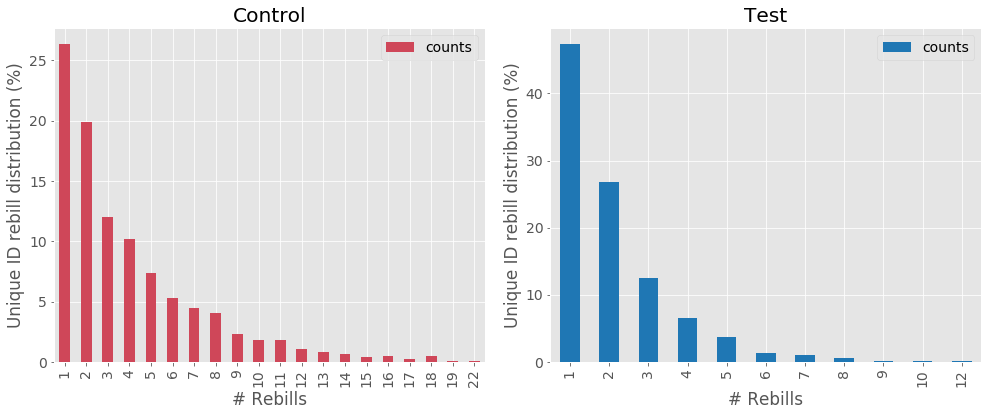

In [8]:
# Variables definitions

ControlCountRebill = pd.DataFrame([Control_Trans['counts'][Control_Trans['transaction_type'] == 'REBILL'].value_counts().sort_index()]).T
ControlCountRebill /= ControlCountRebill.sum() #normalization
ControlCountRebill*=100 # express the results in %

TestCountRebill = pd.DataFrame([Test_Trans['counts'][Test_Trans['transaction_type'] == 'REBILL'].value_counts().sort_index()]).T
TestCountRebill /= TestCountRebill.sum()
TestCountRebill*=100

# Plotting part
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14,6))
ControlCountRebill.plot(ax = axes[0], kind = 'bar',
                             color = '#cf4759',fontsize = 14,
                             title = 'Control');
axes[0].set_xlabel('# Rebills')
axes[0].set_ylabel('Unique ID rebill distribution (%)')

TestCountRebill.plot(ax = axes[1], kind ='bar', color ="#1f77b4", fontsize = 14, title = 'Test');
axes[1].set_xlabel('# Rebills')
axes[1].set_ylabel('Unique ID rebill distribution (%)')

plt.tight_layout()
plt.savefig('RebillDistribution.png', dpi=200)

plt.show()


**Figure 3**: Number of REBILL transactions per unique user ID, for the Control group (left) and for the Test group (right).

From this curve, one can extract the probability that a unique user generates **at least** 1 "REBILL". Basically, it corresponds to the number of unique ID who did at least one REBILL transaction over the total number of unique ID in a given group.  For the control group, $87\%$ are inclined to do so, while the value goes up to $95\%$ for the test group, leading to an absolute difference of $8\%$ ($8.5\%$ relative difference). 

To check the statistical significance of this A/B test, a Bayesian approach is used [^1]. While being easy to implement, it offers a intuitive view of the mean value and the certainty of the measurement related to the sample size (by looking at the spread of the distribution). It also eases the extraction of the p-value by measuring the overlap between the two group distributions. Results are displayed in Figure 4, where one can extract two informations: 

* the mean value, *i.e* the probability that a unique user generates at least one REBILL, is represented by the black vertical lines, for each group (it is obtained using a Monte-Carlo simulation applied on a beta distribution).
* the p-value, defined in this case as the overlap between the two distributions. As there is no overlap between the two, this means that the p-value tends to zero, meaning the test is statistically significant. 

[^1]: For more information about the way it is implemented, one can go to this simple How-to https://www.countbayesie.com/blog/2015/4/25/bayesian-ab-testing 

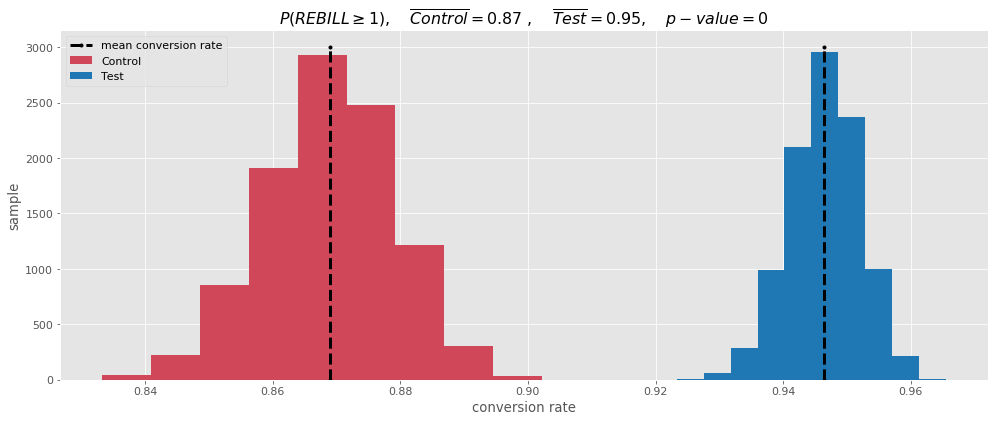

In [14]:
N_sample = 10000

# **Note**: Prior is equal to one as there is "no past". 
# People are put in a category randomly and also chosen randomly to check their transactions
prior_Cont = 1.0
prior_Test = 1.0

ControlPop = Group_Trans_Compare['Control'].sum() # Total population of the Control Group
TestPop = Group_Trans_Compare['Test'].sum() # same for Test group
Control_REBILL = Group_Trans_Compare['Control'][0] # Control group with at least 1 rebill
Test_REBILL = Group_Trans_Compare['Test'][0] # same for Test group

# Monte-Carlo like simulation ==> This will give us the mean conversion rate of the two groups

A_samples = np.random.beta(Control_REBILL+prior_Cont, ControlPop-Control_REBILL+prior_Cont, N_sample)
B_samples = np.random.beta(Test_REBILL+prior_Test, TestPop-Test_REBILL+prior_Test, N_sample)

# p-value calculation, determined by the overlap between the two beta distribution
p_value = 1-sum(B_samples > A_samples)/N_sample

# Plotting
plt.figure(figsize=(14,6))
plt.hist(A_samples, label = 'Control', color ='#cf4759')
plt.plot([A_samples.mean(), A_samples.mean()], [0, 3000], '.--', color = 'black', lw = 3, label = 'mean conversion rate')
plt.hist(B_samples, label = 'Test', color ="#1f77b4")
plt.plot([B_samples.mean(), B_samples.mean()], [0, 3000], '.--', color = 'black', lw = 3)
plt.xlabel('conversion rate')
plt.ylabel('sample')
plt.title('$P(REBILL \geq 1)$,    $\overline{Control} = %.2f$ ,    $\overline{Test} = %.2f$,    $p-value = 0$'\
          % (A_samples.mean(), B_samples.mean()))
plt.legend()
plt.tight_layout()
plt.savefig('Bayesian_Question2.png', dpi=200)
plt.show()


**Figure 4**: Extraction of the probability that an user generates at least 1 "REBILL" and verification of the statistical significance of this study, using Bayesian statistical inference method. 

**Quick Conclusion**: People in the call-in group are 8% more likely to do at least 1 rebill. This test is statistically significant as the p-value is 0, which is < $\alpha = 0.05$ (standardized threshold value)

# 3. Is a user that must call-in to cancel more likely to generate more revenues? 

To answer this question, the total expense of each unique user has to be determined, without considering the associated transaction type. By observing the TransData.csv file, one can see that the different users always do the same operation. Thus, to extract the total expense of each users, one just needs to multiply the "transaction_amount" by the number of operations. 

The associated results are displayed Figure 5, as well as a fit attempt using a Normal distribution. From this, one can extract the values of interest, summarized in the following table: 

|         | mean $\mu$ | standard deviation $\sigma$ |
| :-----: | :--------: | :-------------------------: |
| Control |  83.03\$   |          103.14\$           |
|  Test   |  58.08\$   |           54.90\$           |

Ttest_indResult(statistic=7.3033732709958761, pvalue=4.5551156961474861e-13)


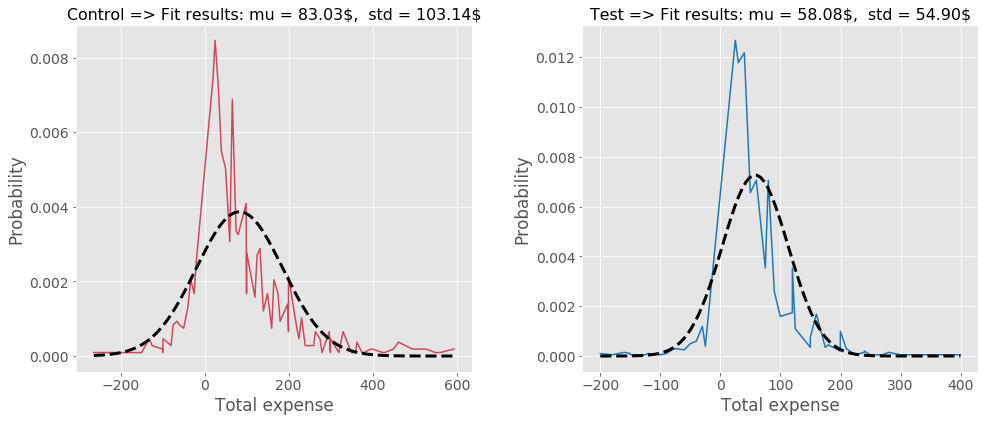

In [10]:
# Fit a normal distribution to the data and extract mean value and std.
TotExpCont = Control_Trans['total_expense']
TotExpTest = Test_Trans['total_expense']

MeanExpCont, StdExpCont = norm.fit(TotExpCont)
MeanExpTest, StdExpTest = norm.fit(TotExpTest)

# p-value
print(ttest_ind_from_stats(MeanExpCont, StdExpCont, ControlPop, MeanExpTest, StdExpTest, TestPop, equal_var=False))

#%% Starting from here, i'm just preparing the data to plot them properly...


# absciss and ordinate of a normal distribution using fit parameters obtained above. 

xControl = np.linspace(TotExpCont.min(), TotExpCont.max(), ControlPop)  
PDF_Control = norm.pdf(xControl, MeanExpCont, StdExpCont)  

xTest = np.linspace(TotExpTest.min(), TotExpTest.max(), 100)
PDF_Test = norm.pdf(xTest, MeanExpTest, StdExpTest) # normal distribution using fit parameters(Test group)

# Fancy titles
titleCont = "Control => Fit results: mu = %.2f\$,  std = %.2f\$" % (MeanExpCont, StdExpCont)
titleTest = "Test => Fit results: mu = %.2f\$,  std = %.2f\$" % (MeanExpTest, StdExpTest)

# preparation of the experimental datas for plotting, with normalization (integration of the whole function)
xExpCont = pd.DataFrame(Control_Trans['total_expense'].value_counts().sort_index())
yExpCont = pd.DataFrame(Control_Trans['total_expense'].value_counts().sort_index())['total_expense']
NormalizationExpCont = xExpCont.apply(np.trapz, axis=0, args=(xExpCont.index,))

xExpTest = pd.DataFrame(TotExpTest.value_counts().sort_index())
yExpTest = pd.DataFrame(TotExpTest.value_counts().sort_index())['total_expense']
NormalizationExpTest = xExpTest.apply(np.trapz, axis=0, args=(xExpTest.index,))


#%% plotting

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14,6))
rcParams.update({'font.size': 11})
axes[0].plot(xExpCont.index,yExpCont/NormalizationExpCont[0] , color = '#cf4759')
axes[0].plot(xControl, PDF_Control, '--', color = 'black', lw = 3)
axes[0].set_xlabel('Total expense')
axes[0].set_ylabel('Probability')
axes[0].set_title(titleCont)

axes[1].plot(xExpTest.index,yExpTest/NormalizationExpTest[0] , color = '#1f77b4')
axes[1].plot(xTest, PDF_Test, '--', color = 'black', lw = 3)
axes[1].set_xlabel('Total expense')
axes[1].set_ylabel('Probability')
axes[1].set_title(titleTest)
plt.tight_layout()
plt.savefig('CompareTotalExpense_question3.png', dpi=200)
plt.show()

**Figure 5**: Total expense distribution and fit (black curve) based on a Normal distribution, for the control group (left,red) and for the test group (right, blue).

When considering only the mean value, one tends to say that users from the test group spend less than those from the control group ($\mu_{test} = 58.08\$ < \mu_{control} = 83.03\$$). However, users from the test group seem to be more consistent, as the standard deviation is lower than the control group one ($\sigma_{test} = 54.90\$ > \sigma_{control} = 103.14\$$), meaning that they are less likely to ask for refunds or chargebacks.

Regarding the statistical significance of this test, a t-test comparing the two distributions gives a p-value of 0, meaning that these results are trustworthy (considering the commonly accepted threshold value $\alpha = 0.05$).

**While not being as obvious as in the previous question, asking user to call-in seems beneficial.**

# 4. Is a user that must call-in more likely to produce a higher chargeback rate?

Here, I got a bit confused with the definition of chargeback rate. The question asks to calculate the chargeback rate defined as the number of chargeback transactions over the number of rebill transactions. Looking at the definition online, it appears that the chargeback rate can also be defined as the number of chargebacks over the total number of transactions (in our case : rebill + refund + chargeback).

To take a decision, a comparison of the two cases is done.

* **Case 1**: Using the question definition, the control group chargeback rate is about $2.6\%$, and about $1.7\%$ for the test group. Using a Bayesian approach, we see this time that the two distributions slightly overlap, leading to a p-value of $0.003$. This is still way below the $\alpha =0.05$ threshold, leading to statistical significance. Results are displayed in Figure 6.

0.004


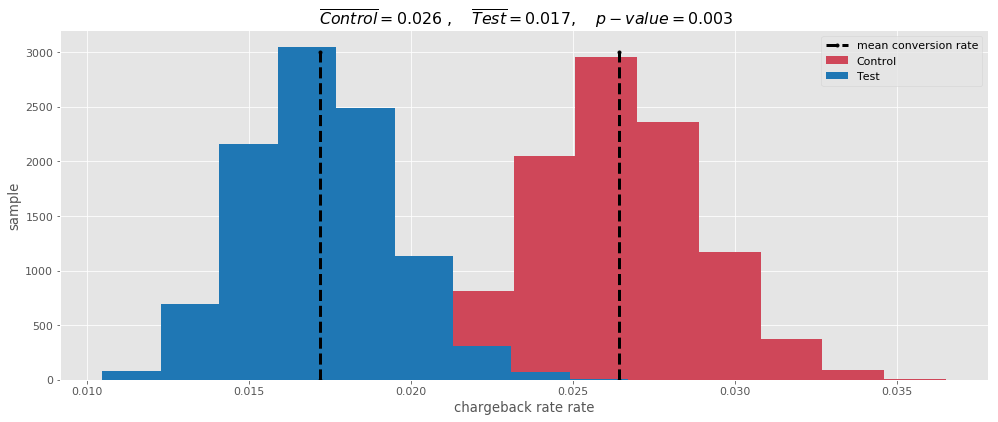

In [11]:
Cont_chargeback_cdt = Control_Trans['transaction_type'] == 'CHARGEBACK'
Test_chargeback_cdt = Test_Trans['transaction_type'] == 'CHARGEBACK'

N_sample = 10000

prior_Cont = 1.0 # no past for this experiment
prior_Test = 1.0

ControlTotTransaction = Control_Trans['counts'].sum()  # Total number of transaction in control group
TestTotTransaction = Test_Trans['counts'].sum()  # same for Test group
Control_chargeback = Control_Trans['counts'][Cont_chargeback_cdt].sum() # number of chargebacks
Test_chargeback = Test_Trans['counts'][Test_chargeback_cdt].sum()  # same for Test group

# Monte-Carlo like simulation ==> This will give us the mean conversion rate of the two groups

A_samplesCR1 = np.random.beta(Control_chargeback+prior_Cont,
                              ControlTotTransaction-Control_chargeback+prior_Cont,
                              N_sample)

B_samplesCR1 = np.random.beta(Test_chargeback+prior_Test,
                              TestTotTransaction-Test_chargeback+prior_Test,
                              N_sample)

# p-value calculation, determined by the overlap between the two beta distribution
p_valueCR1 = 1-sum(B_samplesCR1 < A_samplesCR1)/N_sample  # notice the < sign, in opposition with question 2. 
print(p_valueCR1)

# Plotting
plt.figure(figsize=(14,6))
plt.hist(A_samplesCR1, label = 'Control', color ='#cf4759')
plt.plot([A_samplesCR1.mean(), A_samplesCR1.mean()], [0, 3000], '.--', color = 'black', lw = 3, label = 'mean conversion rate')
plt.hist(B_samplesCR1, label = 'Test', color ="#1f77b4")
plt.plot([B_samplesCR1.mean(), B_samplesCR1.mean()], [0, 3000], '.--', color = 'black', lw = 3)
plt.xlabel('chargeback rate rate')
plt.ylabel('sample')
plt.title(r' $\overline{Control} = %.3f$ ,    $\overline{Test} = %.3f$,    $p-value = 0.003$'\
          % (A_samplesCR1.mean(), B_samplesCR1.mean()))
plt.tight_layout()
plt.savefig('Bayesian_Question4_case1.png', dpi=200)
plt.legend()
plt.show()


**Figure 6**: Extraction of the chargeback rate considering **Case 1** definition and verification of the statistical significance of this study, using Bayesian statistical inference method. 

* **Case 2**: Using the other definition $\left( \frac{\#Chargeback}{\#Total} \right)$, the control group chargeback rate is about $2.8\%$, and about $1.8\%$ for the test group. A p-value of $0.002$ is obtained. Again, these results are significant, considering a threshold value $\alpha = 0.05$.

0.0019


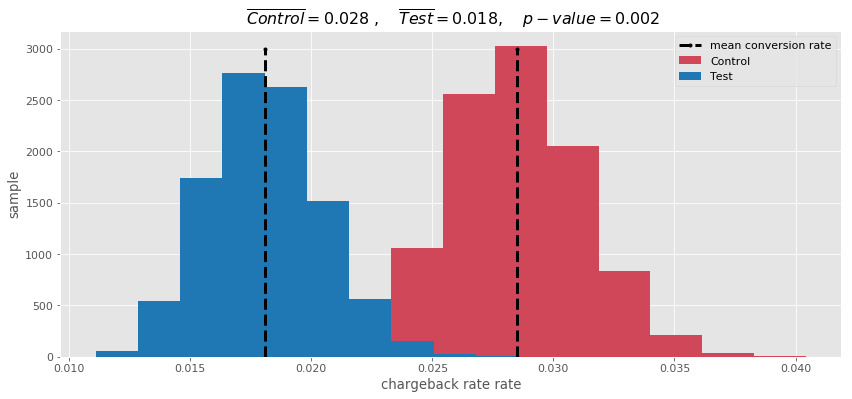

In [12]:
# Get number of rebills transaction for both groups
ControlTotTransaction = Control_Trans['counts'][Control_Trans['transaction_type'] == 'REBILL'].sum() 
TestTotTransaction = Test_Trans['counts'][Test_Trans['transaction_type'] == 'REBILL'].sum()

# Monte-Carlo like simulation ==> This will give us the mean conversion rate of the two groups

A_samplesCR2 = np.random.beta(Control_chargeback+prior_Cont, 
                              ControlTotTransaction-Control_chargeback+prior_Cont,
                              N_sample)
B_samplesCR2 = np.random.beta(Test_chargeback+prior_Test,
                            TestTotTransaction-Test_chargeback+prior_Test,
                            N_sample)

# p-value calculation, determined by the overlap between the two beta distribution
p_value2 = 1-sum(B_samplesCR2 < A_samplesCR2)/N_sample
print(p_value2)

# Plotting
plt.figure(figsize=(14,6))
plt.hist(A_samplesCR2, label = 'Control', color ='#cf4759')
plt.plot([A_samplesCR2.mean(), A_samplesCR2.mean()], [0, 3000],
         '.--', color = 'black', lw = 3, label = 'mean conversion rate')

plt.hist(B_samplesCR2, label = 'Test', color ="#1f77b4")
plt.plot([B_samplesCR2.mean(), B_samplesCR2.mean()], [0, 3000],
         '.--', color = 'black', lw = 3)

plt.xlabel('chargeback rate rate')
plt.ylabel('sample')
plt.title(r' $\overline{Control} = %.3f$ ,    $\overline{Test} = %.3f$,    $p-value = 0.002$'\
          % (A_samplesCR2.mean(), B_samplesCR2.mean()))
plt.legend()
plt.savefig('Bayesian_Question4_case2.png', dpi=200)
plt.legend()
plt.show()

**Figure 7**: Extraction of the chargeback rate considering **Case 2** definition and verification of the statistical significance of this study, using Bayesian statistical inference method. 

As in our situation, there is no major difference between the two cases ($\Delta_{CR} \approx 0.1-0.3\%$), the result from the question definition will be used. 

Thus, the chargeback rate of the test group is $35\%$ lower than the control group chargeback rate ($\Delta_{CR} = 2.6-1.7 = 0.9\%$), meaning that the call-in setup is limiting chargeback requests.

## Conclusion

From this study, the call-in system appears as a promising alternative to ensure:

* a higher rebill rate ($95\%$ for the test group against $87\%$ for the control group)
* a more reproducible behavior in term of total expense (lower mean value of the total expense but also lower standard deviation)
* a good way to limit chargeback rate. This point is of great importance as chargeback rate can be associated to fraud. Moreover, a high chargeback rate can lead to penalties or supplementary fees from bank organizations. 

It should be applied permanently.

-------------------------
*Extra study to check the population distribution of the number of chargeback + refund. Similar to Figure 3*

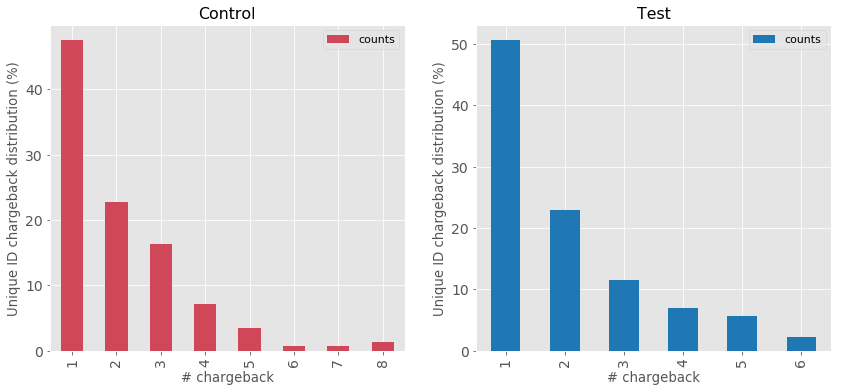

In [13]:
Cont_chargeback_cdt = (Control_Trans['transaction_type'] == 'CHARGEBACK') | (Control_Trans['transaction_type'] == 'REFUND')
Test_chargeback_cdt = (Test_Trans['transaction_type'] == 'CHARGEBACK') | (Test_Trans['transaction_type'] == 'REFUND')

ControlCountChargeback = pd.DataFrame(Control_Trans['counts'][Cont_chargeback_cdt].value_counts().sort_index())
ControlCountChargeback/=ControlCountChargeback.sum()
ControlCountChargeback*=100

TestCountChargeback = pd.DataFrame(Test_Trans['counts'][Test_chargeback_cdt].value_counts().sort_index())
TestCountChargeback /= TestCountChargeback.sum()
TestCountChargeback *= 100

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14,6))

ControlCountChargeback.plot(ax = axes[0], kind = 'bar', color = '#cf4759', fontsize = 14, title = 'Control')
axes[0].set_xlabel('# chargeback')
axes[0].set_ylabel('Unique ID chargeback distribution (%)')
TestCountChargeback.plot(ax = axes[1], kind = 'bar', color = '#1f77b4', fontsize = 14, title = 'Test')
axes[1].set_xlabel('# chargeback')
axes[1].set_ylabel('Unique ID chargeback distribution (%)')
plt.show()